In [52]:
import numpy as np
from math import *

In [53]:
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
COST_OF_MOVING = 2

In [54]:
policy = np.zeros((MAX_CARS+1, MAX_CARS+1))
stateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))

In [55]:
states = []
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        states.append([i,j])

In [56]:
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS+1)

In [57]:
pBackup = dict()

def poisson(x, lam):
    global pBackup
    key = x*10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam,x) / factorial(x)
    return pBackup[key]

In [58]:
POISSON_UPPER_BOUND = 11

In [59]:
newStateVal = np.zeros((MAX_CARS+1, MAX_CARS+1))
improvePolicy = False
policyStable = False

In [60]:
def expectedReturn(state, action, stateValue):
    # Initiate and populate returns with cost associated with moving cars
    returns = 0.0
    returns -= COST_OF_MOVING * np.absolute(action)
    # Number of cars to start the day
    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))
    # Iterate over Rental Rates
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            # Rental Probabilities
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS) * poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            # Total Rentals
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            # Total Rewards
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT
            # Iterate over Return Rates
            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    # Return Rate Probabilities
                    prob = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS) * poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS) * rentalsProb
                    # Number of cars at the end of the day
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    # Number of cars at the end of the day
                    returns += prob * (rewards + DISCOUNT_RATE * stateValue[carsLoc1_prime, carsLoc2_prime])
    return returns

In [61]:
while policyStable == False:
    ## Policy Evaluation
    print("Policy Eval")
    delta = 0.0
    for i,j in states:
        v = stateVal[i,j].copy()
        stateVal[i,j] = expectedReturn([i,j], policy[i,j], stateVal)
        delta = np.maximum(delta, np.absolute(v-stateVal[i,j]))
    print(delta)
    if delta < 1e-4:
        print("Almost converged")
        improvePolicy = True

    ## Policy Improvement
    if improvePolicy == True:
        print("Improve Policy")
        newPolicy = np.zeros((MAX_CARS+1, MAX_CARS+1))
        for i,j in states:
            actionReturns = []
            for action in actions:
                if ((action >= 0) and (i >= action)) or ((action < 0) and j >= np.absolute(action)):
                    actionReturns.append(expectedReturn([i,j], action, stateVal))
                else:
                    actionReturns.append(-float('inf'))
            bestAction = np.argmax(actionReturns)
            newPolicy[i,j] = actions[bestAction]
        policyChanges = np.sum(newPolicy != policy)

        policy = newPolicy
        improvePolicy = False

        if policyChanges == 0:
            policyStable = True
    
# exec time: 120 min

Policy Eval
191.1404442545006
Policy Eval
131.91909180411537
Policy Eval
88.61937127296494
Policy Eval
66.27613430095823
Policy Eval
52.304040346176976
Policy Eval
40.50431282688419
Policy Eval
31.571819689709855
Policy Eval
25.009002907688227
Policy Eval
20.776212359973727
Policy Eval
17.373214856382276
Policy Eval
14.489145965680791
Policy Eval
12.054381189472394
Policy Eval
10.005913044444071
Policy Eval
8.28806058889046
Policy Eval
6.85197859667943
Policy Eval
5.654991085770405
Policy Eval
4.6599910305831145
Policy Eval
3.8349060091838965
Policy Eval
3.152195244708878
Policy Eval
2.588360954112204
Policy Eval
2.1234741080099298
Policy Eval
1.7407223622979586
Policy Eval
1.4259887280389307
Policy Eval
1.1674672474201202
Policy Eval
0.9553189041118912
Policy Eval
0.7813683111010619
Policy Eval
0.6388397394877643
Policy Eval
0.5221297762512336
Policy Eval
0.4266132009904595
Policy Eval
0.3484783938996543
Policy Eval
0.28458859575198403
Policy Eval
0.2323655270653262
Policy Eval
0.1896

In [64]:
np.save("/system/user/studentwork/mederits/Research/RL/jacks_car_rental_policy_GPI_inplace_version.npy", policy)

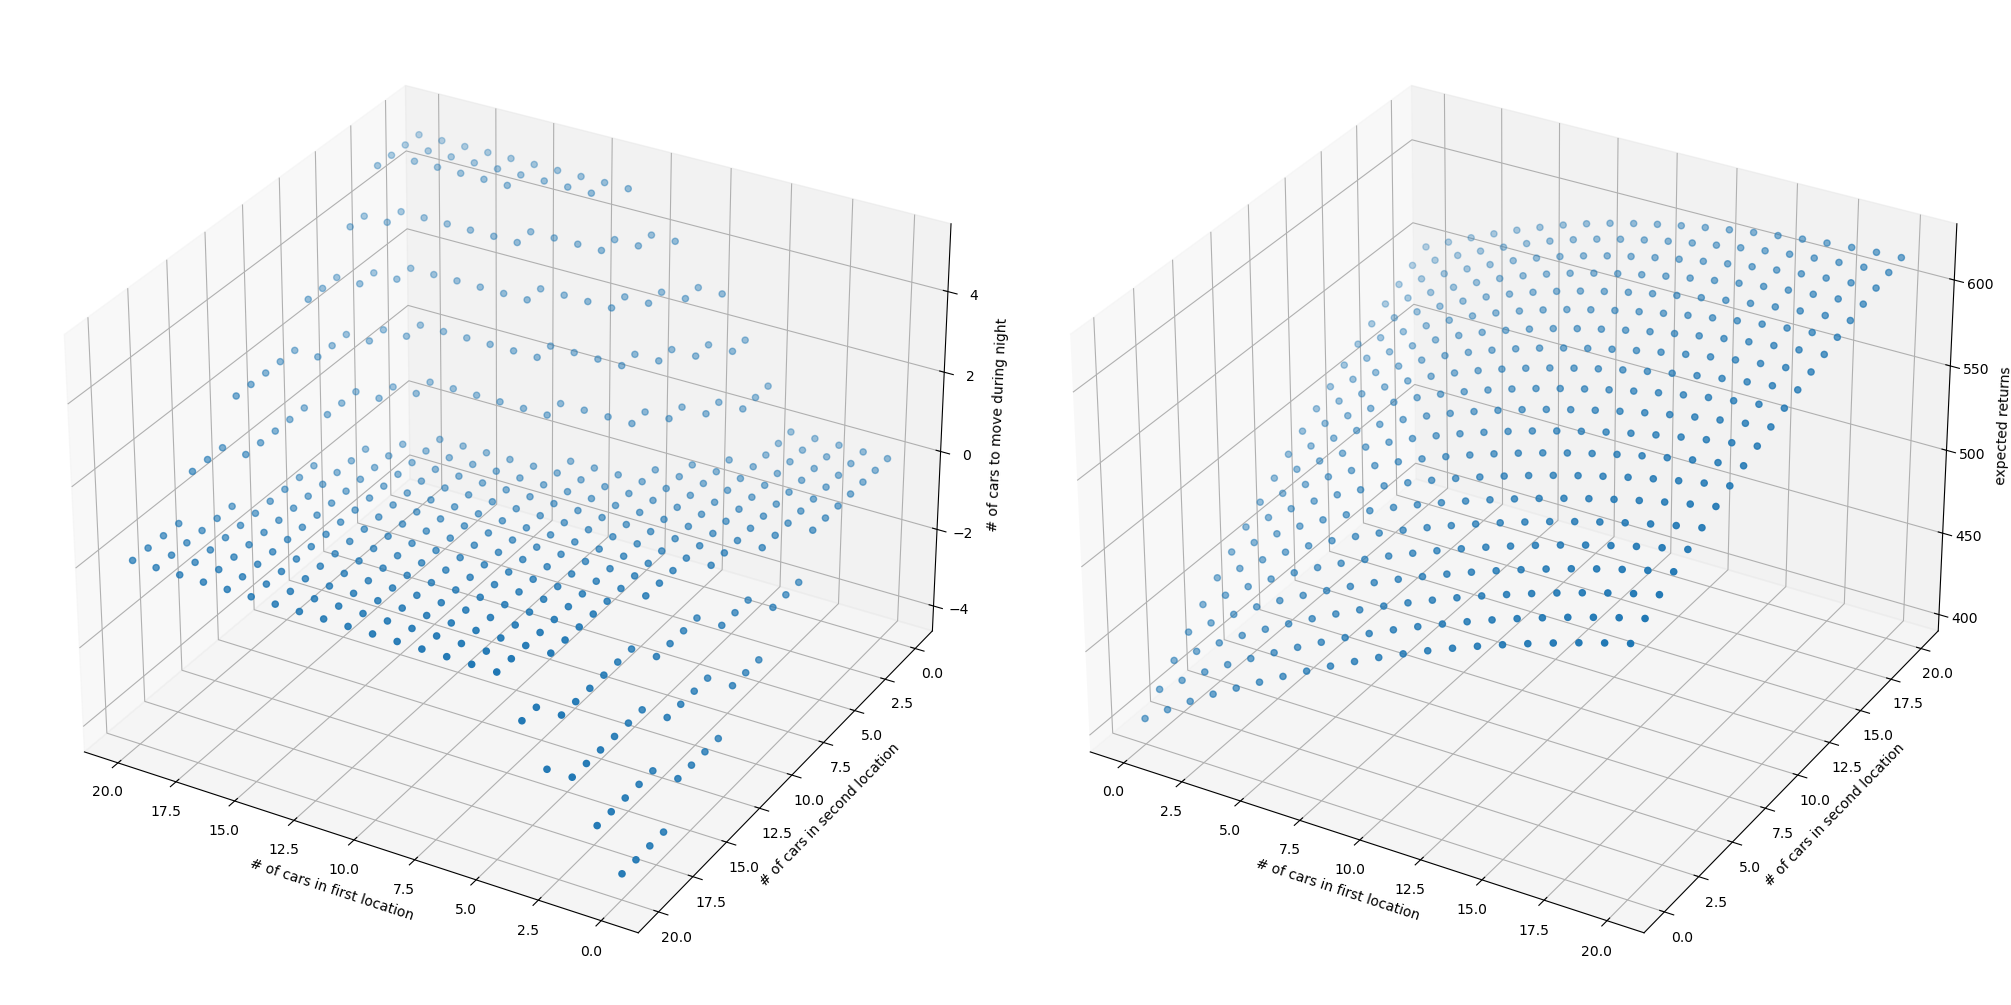

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure(figsize=(20,10), layout="constrained")
ax = fig.add_subplot(1,2,1, projection='3d')

m = 'o'

cars_loc1 = []
cars_loc2 = []
policy_list = []
value_list = []

for i,j in states:
    cars_loc1.append(i)
    cars_loc2.append(j)
    policy_list.append(policy[i,j])
    value_list.append(stateVal[i,j])

ax.scatter(cars_loc1, cars_loc2, policy_list, marker=m)

ax.set_xlabel('# of cars in first location')
ax.set_ylabel('# of cars in second location')
ax.set_zlabel('# of cars to move during night')

ax.xaxis.set_inverted(True)
ax.yaxis.set_inverted(True)

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(cars_loc1, cars_loc2, value_list, marker=m)

ax2.set_xlabel('# of cars in first location')
ax2.set_ylabel('# of cars in second location')
ax2.set_zlabel('expected returns')

ax2.xaxis.set_inverted(False)
ax2.yaxis.set_inverted(False)

plt.show()

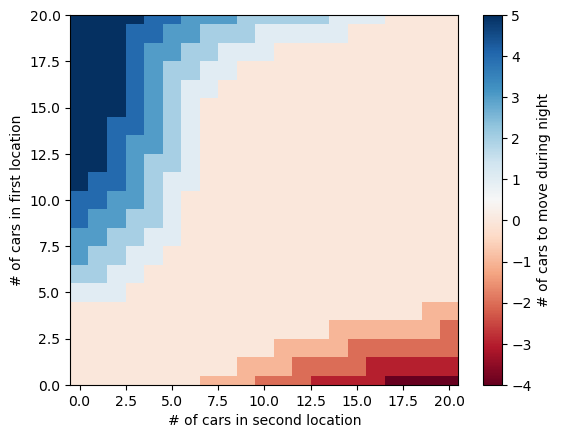

In [63]:
plt.imshow(policy, cmap='RdBu', interpolation='nearest')
plt.ylim([0,20])
cbar = plt.colorbar()
cbar.set_label('# of cars to move during night', rotation=90)


plt.xlabel("# of cars in second location")
plt.ylabel("# of cars in first location")
plt.show()